In [15]:
import audio_functions as af
from audio_file_iterator import iter as audio_file_iterator
import soundfile as sf
import pandas as pd
import numpy as np
import os
import librosa
import librosa.feature
from tqdm import tqdm
from random import randint
import plot
import yaml

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Preprocessing of the audio files
Perform some steps to preprocess audio files and convert them into a feature vector
## Preprocess converted WAV files
### Read in the audio data from the directory structure
read in the data and store the audio content together with the directory path to save the information of the associatated class label

In [2]:
loaded_audio_files, dirs = zip(*[ (sf.read(audio_file_name, dtype='float32'), os.path.dirname(audio_file_name)) for audio_file_name in audio_file_iterator()])

Processing genre directory '09 Disco Funk'
   Processed 298 files          
Processing genre directory '12 Chinese Traditional'
   Processed 300 files          
Processing genre directory '15 Reggaeton Pop'
   Processed 322 files          
Processing genre directory '06 Deep House'
   Processed 360 files          
Processing genre directory 'Keyboard Collection'
   Processed 164 files          


# Read in config file

In [ ]:
# read in the config
with open('preprocess_config.yaml', 'r') as f:
    config = yaml.safe_load(f)

## One Hot Encoding
Get the directory names form the data folder, which are used to identify the name of the classes and encode the feature labels using a One-Hot-Encoding.

In [3]:
from sklearn.preprocessing import OneHotEncoder

class_idx = 0
# remove leading directory name
sliced_dir_names = list(map(lambda s: s.replace('wav_data\\', ''), dirs))

ohe = OneHotEncoder()
ohe_labels = ohe.fit_transform(np.array(sliced_dir_names).reshape(-1, 1))

cats = ohe.categories_[0]
print("Categories ({n}):".format(n=len(cats)))
[print("   ", cat) for cat in cats]

ohe_labels_array = ohe_labels.toarray()

Categories (5):
    wav_data/06 Deep House
    wav_data/09 Disco Funk
    wav_data/12 Chinese Traditional
    wav_data/15 Reggaeton Pop
    wav_data/Keyboard Collection


Save the label vector and the class mapping to seperate files

### perform sequential several preprocessing steps
 - slice audio to 3s unit length snippets (zero-padded if shorter)
 - convert track to mono audio
 - downsample audio files to 4kBit

First, all samples are cut into a unit time length and stored in a list of tuples, where each list elements is a tuple, consisting of a 3-second audio snippet and its samplerate

In [4]:
unit_length = config['unit_length_ms']
downsample_rate = config['downsample_rate']

In [5]:
to_multi_slices = lambda t: (af.multi_slice_to_length(t[0], t[1], unit_length), t[1])

unit_length_audio = tqdm(map(to_multi_slices, loaded_audio_files))

unit_length_audio, sr = zip(*unit_length_audio)

appended_slice_lengths = [len(u) for u in unit_length_audio]

unit_length_audio = [item for sublist in unit_length_audio for item in sublist]

print("Number of unit length samples:", len(unit_length_audio))

assert sum(appended_slice_lengths) == len(unit_length_audio)

1444it [00:01, 786.59it/s] 

Number of unit length samples: 4068


Append the label vector according to the appended features  
Since some of the features has been duplicated because of the slicing to unit length, so the label vector has to be extended too

In [6]:
ohe_labels_array_extended = ohe_labels_array

offset = 0

for idx, append_size in enumerate(appended_slice_lengths):
    if append_size == 1:
        continue
    to_insert = np.tile(ohe_labels_array[idx, :], (append_size-1, 1))
    ohe_labels_array_extended = np.insert(ohe_labels_array_extended, idx+1+offset, to_insert, axis=0)
    offset += append_size-1

print(ohe_labels_array_extended.shape[0])
assert sum(appended_slice_lengths) == ohe_labels_array_extended.shape[0]

4068


Save extended label vector and the category mapping

In [7]:
import json

np.save('data/labels.npy', ohe_labels_array_extended)

cats_dict = {}
for i, c in enumerate(cats):
    cats_dict[c.removeprefix('wav_data/')] = i

with open('data/class_label_index_mapping.json', 'w') as f:
    json.dump(cats_dict, f, indent=4)

define and prepare preprocessing steps with the corresponding parameters:

In [26]:
to_mono = lambda t : (af.to_mono_channel(t[0]), t[1])
resample = lambda t : (af.resample(t[0], t[1], downsample_rate), t[1])

preprocessing_steps = [
    to_mono,
    resample
]

features_preprocessed = unit_length_audio
for step in preprocessing_steps:
    features_preprocessed = map(step, features_preprocessed)

perform preprocessing from generator-pipline and extract the features as an numpy-array

In [ ]:
features, _ = zip(*tqdm(features_preprocessed))
feature_array = np.vstack(features)

### Store the data
Save the data in numpy format  
Summary:
- samples of 3 seconds length
- sample rate of 4kHz
- mono audio
- samples whose length was above 3 seconds were sliced into multiple snippets, with the last snippet being zero-padded in the end 

In [9]:
from save_utils import save_numpy_array_sliced

print("Feature array uses {s:.2f} MB of disc space".format(s=feature_array.nbytes/1024/1024))

save_numpy_array_sliced('preprocessed_data', feature_array)

Feature array uses 186.22 MB of disc space
Saved file to slices preprocessed_data
   saved slice 1 to  preprocessed_data_1
   saved slice 2 to  preprocessed_data_2
   saved slice 3 to  preprocessed_data_3


### Validation  
Load the file with the stored feature arrays

In [10]:
from save_utils import load_sliced_numpy_array

feature_array = load_sliced_numpy_array('preprocessed_data')

print(feature_array.shape)

Loaded 3 files:
    preprocessed_data_1.npy
    preprocessed_data_2.npy
    preprocessed_data_3.npy
(4068, 12000)


Plot a random example of a waveform from the preprocessed data to verify the preprocessing steps  
The saved data are laoded before

Plot audio sample 3584
Dimensions: (12000,)


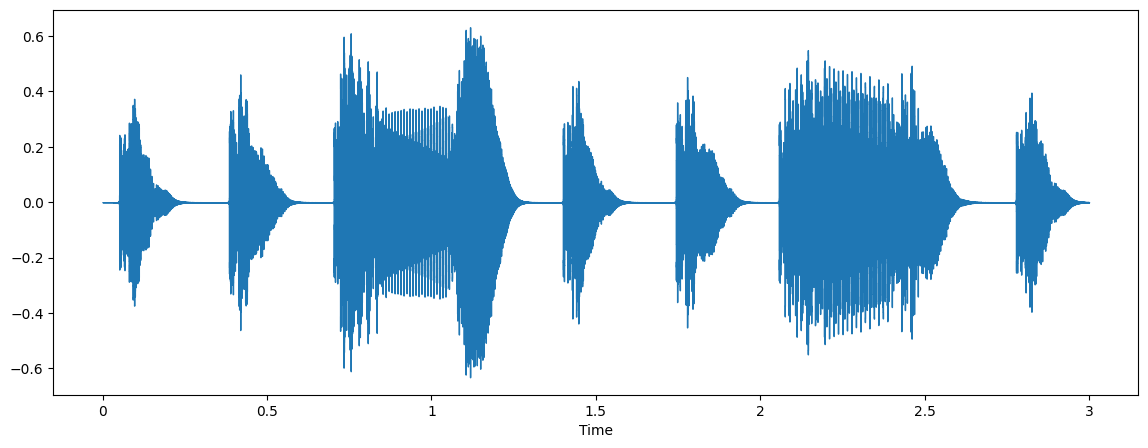

In [29]:
x = randint(0, len(feature_array)-1)
random_feature = feature_array[x, :]

print("Plot audio sample", x)
plot.plot_waveform(random_feature, downsample_rate)

print("Dimensions:", random_feature.shape)

# Check for correct sample rate, length and for mono-track
assert random_feature.shape[0] == unit_length*downsample_rate/1000 and len(random_feature.shape) == 1

## Compute the melspectogram from the features

In [8]:
to_mono = lambda t : (af.to_mono_channel(t[0]), t[1])

print("Convert to mono lenght")
mono_unit_length_audio, s_rates = zip(*tqdm(map(to_mono, unit_length_audio)))
print("Stack to a single matrix")
mono_unit_length_audio_array = np.vstack(mono_unit_length_audio)

print(mono_unit_length_audio_array.shape)

Convert to mono lenght


4068it [00:11, 340.19it/s]


Stack to a single matrix
(4068, 132300)


In [21]:
sample_rate = s_rates[0]
n_mels = config['melspectogram']['n_mels']
f_max = sample_rate/2
hop_length = config['melspectogram']['hop_length']

get_melspectogram = lambda t: librosa.power_to_db(librosa.feature.melspectrogram(y=t, sr=sample_rate, n_mels=n_mels, fmax=f_max, hop_length=hop_length)).flatten()
#get_spectogram_db = lambda t : librosa.power_to_db(np.abs(librosa.feature.melspectrogram(y=t, sr=downsample_rate, n_fft=32, hop_length=256, power=2.0, n_mels=64)))

print("Compute the melspectogram")
features_spectogram = list(tqdm(map(get_melspectogram, mono_unit_length_audio_array)))

print("Stack to a single matrix")
features_spectogram = np.vstack(features_spectogram)

print("Shape of the feature vector:", features_spectogram.shape)

Compute the melspectogram


4068it [00:36, 111.39it/s]


Stack to a single matrix
Shape of the feature vector: (4068, 33152)


### Save the melspectogram arrays

In [22]:
from save_utils import save_numpy_array_sliced

print("Feature array uses {s:.2f} MB of disc space".format(s=features_spectogram.nbytes/1024/1024))

save_numpy_array_sliced('melspec_features', features_spectogram, max_size_mb=45)

Feature array uses 514.46 MB of disc space
Saved file to slices melspec_features
   saved slice 001 to  melspec_features_001
   saved slice 002 to  melspec_features_002
   saved slice 003 to  melspec_features_003
   saved slice 004 to  melspec_features_004
   saved slice 005 to  melspec_features_005
   saved slice 006 to  melspec_features_006
   saved slice 007 to  melspec_features_007
   saved slice 008 to  melspec_features_008
   saved slice 009 to  melspec_features_009
   saved slice 010 to  melspec_features_010
   saved slice 011 to  melspec_features_011
   saved slice 012 to  melspec_features_012


### Load and validate
Load the melspectogram features and plot an example

In [18]:
from save_utils import load_sliced_numpy_array
from random import randint

features_spectogram = load_sliced_numpy_array('melspec_features')

x = randint(0, features_spectogram.shape[0]-1)

feature_to_plot = features_spectogram[x, :].reshape(n_mels, -1)

plot.plot_melspectogram(feature_to_plot, sample_rate, fmax=f_max, calculate_db=False, save_fig=False)

Loaded 3 files:
    melspec_features_001.npy
    melspec_features_002.npy
    melspec_features_003.npy


Traceback (most recent call last):
  File "_pydevd_bundle/pydevd_cython.pyx", line 1134, in _pydevd_bundle.pydevd_cython.PyDBFrame.trace_dispatch
  File "_pydevd_bundle/pydevd_cython.pyx", line 311, in _pydevd_bundle.pydevd_cython.PyDBFrame.do_wait_suspend
  File "/Users/mstuffer/.pyenv/versions/3.9.15/envs/ai-industry/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 2062, in do_wait_suspend
    keep_suspended = self._do_wait_suspend(thread, frame, event, arg, suspend_type, from_this_thread, frames_tracker)
  File "/Users/mstuffer/.pyenv/versions/3.9.15/envs/ai-industry/lib/python3.9/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 2098, in _do_wait_suspend
    time.sleep(0.01)
KeyboardInterrupt


KeyboardInterrupt: 